In [1]:
import numpy as np
import pandas as pd
import subprocess as sp
import itertools as it
import sys, re, collections
import scipy as sc
import pgenlib as pg

In [2]:
%matplotlib inline
import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt

/home/ytanigaw/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def make_plot(x, y, title = None, xlabel = None, ylabel = None, filename = None):
    '''
    This function generates histogram of a vector x and save to file
    Inputs:
      x: data vector
      title:    title of the plot
      xlabel:   label on x-axis
      ylabel:   label on y-axis
      filename: name of the image file (if given, save to file)
    Returns:
      matlab plot object
    Side effect:
      save an image file if filename is given
    '''
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y)
    
    if(xlabel != None):
        ax.set_xlabel(xlabel)
    if(ylabel != None):
        ax.set_ylabel(ylabel)
    if(title != None):
        ax.set_title(title)
    if(filename != None):
        fig.savefig(filename)


In [4]:
times_f = './poretools_time.12763870.stats'

In [5]:
#times_df = pd.read_csv(times_f, sep = '\t', nrows=100)

In [6]:
times_df = pd.read_csv(times_f, sep = '\t')

In [7]:
times_df.head(10)

,channel,filename,read_length,exp_starttime,unix_timestamp,duration,unix_timestamp_end,iso_timestamp,day,hour,minute
0,391,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,4652,1479439380,1479460809,11,1479460820,2016-11-18T01:20:09+0000,18,1,20
1,117,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,20943,1474445279,1474454776,114,1474454890,2016-09-21T03:46:16+0000,21,3,46
2,248,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,29960,1474320208,1474320476,120,1474320596,2016-09-19T14:27:56+0000,19,14,27
3,201,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,691,1468628094,1468633151,6,1468633157,2016-07-15T18:39:11+0000,15,18,39
4,95,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,3341,1468591707,1468592897,52,1468592949,2016-07-15T07:28:17+0000,15,7,28
5,282,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,3650,1468574203,1468579168,25,1468579193,2016-07-15T03:39:28+0000,15,3,39
6,296,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,4903,1476562940,1476564188,11,1476564199,2016-10-15T13:43:08+0000,15,13,43
7,66,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,9101,1480343031,1480383624,21,1480383645,2016-11-28T17:40:24+0000,28,17,40
8,47,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,6343,1468574203,1468579212,44,1468579256,2016-07-15T03:40:12+0000,15,3,40
9,309,/scratch/PI/mrivas/data/NA12878-fast5/rel3/${c...,10415,1474432874,1474437134,49,1474437183,2016-09-20T22:52:14+0000,20,22,52


In [8]:
times_df.shape

(2772, 11)

- this is the dataset for chr20 part5 (6.8 G)
  - https://github.com/nanopore-wgs-consortium/NA12878
- part 1-4 are 300Gb each

## time = 0 is ambiguous: multiple 'exp_starttime's

In [9]:
len(set(times_df['exp_starttime']))

309

In [10]:
times_df['filename'][:10].as_matrix().tolist()

['/scratch/PI/mrivas/data/NA12878-fast5/rel3/${chr}/${fn}//makeson_PC_20161117_FNFAB44989_MN17284_sequencing_run_MA_470_R9_4_NA12878_11_17_16_64834_ch391_read9096_strand.fast5',
 '/scratch/PI/mrivas/data/NA12878-fast5/rel3/${chr}/${fn}//MinION2_20160921_FNFAB39075_MN16454_sequencing_run_Chip97_Human_R9_4_tuned_89079_ch117_read481_strand.fast5',
 '/scratch/PI/mrivas/data/NA12878-fast5/rel3/${chr}/${fn}//PLSP61583_20160919_FNFAB390088_MN17048_sequencing_run_Hum_94_30150_ch248_read28_strand.fast5',
 '/scratch/PI/mrivas/data/NA12878-fast5/rel3/${chr}/${fn}//MinION2_20160715_FNFAB23716_MN16454_sequencing_run_Chip86_Human_1D_Rapid_Tuned2_17351_ch201_read2350_strand.fast5',
 '/scratch/PI/mrivas/data/NA12878-fast5/rel3/${chr}/${fn}//MinION2_20160715_FNFAB23716_MN16454_sequencing_run_Chip86_Human_1D_Rapid_Tuned_33536_ch95_read77_strand.fast5',
 '/scratch/PI/mrivas/data/NA12878-fast5/rel3/${chr}/${fn}//MinION2_20160715_FNFAB23716_MN16454_sequencing_run_Chip86_Human_1D_Rapid_Tuned_19118_ch282_rea

## make a plot

In [11]:
times_df['relative_end'] = times_df['unix_timestamp_end'] - times_df['exp_starttime']

In [12]:
times_df_sorted = times_df.sort_values(by = ['relative_end'], ascending=[1])

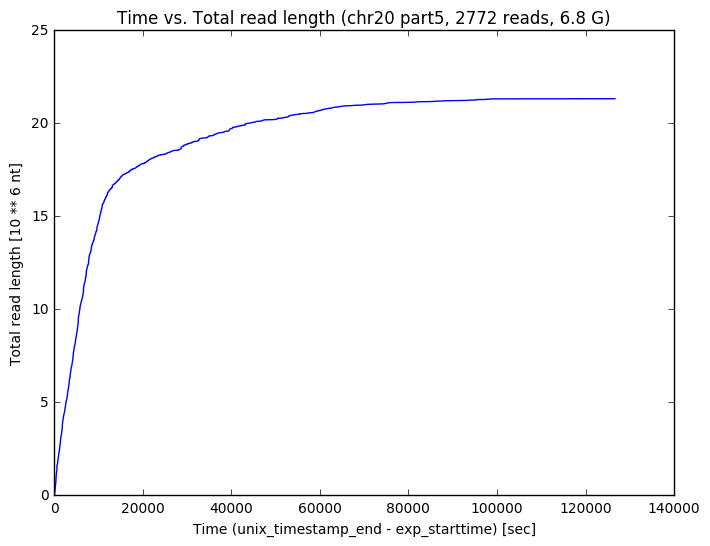

In [13]:
make_plot(times_df_sorted['relative_end'].as_matrix(), 
          np.cumsum(times_df_sorted['read_length'].as_matrix()) * 10 ** (-6),
          title = 'Time vs. Total read length (chr20 part5, 2772 reads, 6.8 G)',
          xlabel = 'Time (unix_timestamp_end - exp_starttime) [sec]', 
          ylabel = 'Total read length [10 ** 6 nt]', 
          filename = '20170211_Time_vs_Total_read_length_plot.png')